In [15]:
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nibabel.processing as nibpro
import SimpleITK as sitk
import json
import matplotlib.patches as mpatches
from pathlib import Path
from PIL import Image, ImageEnhance
from matplotlib import cm
import matplotlib
import re
if not str(Path("../..").resolve()) in sys.path:
    sys.path.append(str(Path("../..").resolve()))
from slice_inflate.datasets.align_mmwhs import nifti_transform, cut_slice, crop_around_label_center

c3d = "/shared/slice_inflate/c3d-1.1.0-Linux-x86_64/bin/c3d"

### Prepare MMWHS: Orient main volume by Slicer3D view

In [2]:
def plot_slices(red_slice, green_slice, yellow_slice, vmin=0.0, vmax=1.0):
    fig_img = plt.figure()
    new_plot = fig_img.add_subplot(131)
    plt.imshow(red_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)
    new_plot = fig_img.add_subplot(132)
    plt.imshow(green_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)
    new_plot = fig_img.add_subplot(133)
    plt.imshow(yellow_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)

    axs = fig_img.axes
    axs[0].set_title("red")
    axs[1].set_title("green")
    axs[2].set_title("yellow")
    plt.show()

In [3]:
mmwhs_base_path = "../../data/MMWHS"

mri_1002_nii = nib.load(Path(mmwhs_base_path, "mr_test_selection/mr_train_1002_image.nii.gz"))
mri_1002_gt_nii = nib.load(Path(mmwhs_base_path, "mr_test_selection/mr_train_1002_label.nii.gz"))

red_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_HLA_red_slice_to_ras.mat"))
yellow_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA_yellow_slice_to_ras.mat"))

FOV_MM = torch.tensor([300,300,300])
FOV_VOX = torch.tensor([200,200,200])
# CROP_SIZE = torch.tensor([128,128,-1])

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


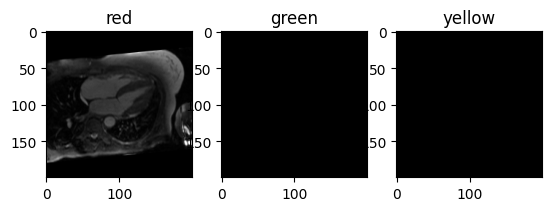

In [10]:
red_volume, red_affine = nifti_transform(
    torch.as_tensor(mri_1002_nii.get_fdata()).unsqueeze(0).unsqueeze(0), 
    torch.as_tensor(mri_1002_nii.affine).unsqueeze(0), 
    red_slice_to_ras_mat.unsqueeze(0), 
    fov_mm=FOV_MM, 
    fov_vox=FOV_VOX)

red_label, _ = nifti_transform(
    torch.as_tensor(mri_1002_gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0), 
    torch.as_tensor(mri_1002_gt_nii.affine).unsqueeze(0), 
    red_slice_to_ras_mat.unsqueeze(0), fov_mm=FOV_MM, 
    fov_vox=FOV_VOX, is_label=True)

# red_label, red_volume, red_affine = \
#     crop_around_label_center(red_label, vox_size=CROP_SIZE, image=red_volume, affine=red_affine)

ref_img_path = Path(mmwhs_base_path, "preprocessed/train_HLA_4_chamber/mr_train_1002_image_HLA.nii.gz")
ref_label_path = Path(mmwhs_base_path, "preprocessed/train_HLA_4_chamber/mr_train_1002_label_HLA.nii.gz")
ref_img_path.parent.mkdir(exist_ok=True, parents=True)

red_slice = cut_slice(red_volume)

red_volume = red_volume.squeeze()
red_label = red_label.squeeze()
red_slice = red_slice.squeeze()

nib.save(nib.Nifti1Image(red_volume.numpy(), affine=red_affine.squeeze()), ref_img_path)
nib.save(nib.Nifti1Image(red_label.int().numpy(), affine=red_affine.squeeze()), ref_label_path)

plot_slices(red_slice, torch.zeros_like(red_slice), torch.zeros_like(red_slice), vmax=red_volume.max().item())

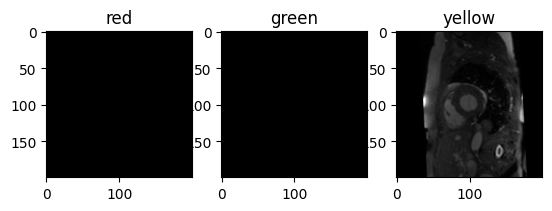

In [12]:
yellow_volume, yellow_affine = nifti_transform(
    torch.as_tensor(mri_1002_nii.get_fdata()).unsqueeze(0).unsqueeze(0), 
    torch.as_tensor(mri_1002_nii.affine).unsqueeze(0), 
    yellow_slice_to_ras_mat.unsqueeze(0), 
    fov_mm=FOV_MM, 
    fov_vox=FOV_VOX)

yellow_label, _ = nifti_transform(
    torch.as_tensor(mri_1002_gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0), 
    torch.as_tensor(mri_1002_gt_nii.affine).unsqueeze(0), 
    yellow_slice_to_ras_mat.unsqueeze(0), fov_mm=FOV_MM, 
    fov_vox=FOV_VOX, is_label=True)

ref_img_path = Path(mmwhs_base_path, "preprocessed/train_SA/mr_train_1002_image_SA.nii.gz")
ref_label_path = Path(mmwhs_base_path, "preprocessed/train_SA/mr_train_1002_label_SA.nii.gz")
ref_img_path.parent.mkdir(exist_ok=True, parents=True)

yellow_slice = cut_slice(yellow_volume)

yellow_volume = yellow_volume.squeeze()
yellow_label = yellow_label.squeeze()
yellow_slice = yellow_slice.squeeze()

nib.save(nib.Nifti1Image(yellow_volume.numpy(), affine=yellow_affine.squeeze()), ref_img_path)
nib.save(nib.Nifti1Image(yellow_label.int().numpy(), affine=yellow_affine.squeeze()), ref_label_path)

plot_slices(torch.zeros_like(yellow_slice), torch.zeros_like(yellow_slice), yellow_slice, vmax=yellow_volume.max().item())

### Prepare MMWHS: Register volumes based on 1002 fixed labels with c3d and store the affine

In [13]:
mmwhs_base_path = "../../data/MMWHS"

FIXED_ID = 1002
moving_ids = list(range(1001, 1021, 1))

orig_fixed_label_filepath = Path(mmwhs_base_path, "mr_test_selection", f"mr_train_{FIXED_ID}_label.nii.gz")
orig_fixed_image_filepath = Path(mmwhs_base_path, "mr_test_selection", f"mr_train_{FIXED_ID}_image.nii.gz")

nii_orig_label = nib.load(orig_fixed_label_filepath)
nii_orig_image = nib.load(orig_fixed_image_filepath)

CROP_SIZE = torch.tensor([256,256,128])

orig_label = torch.as_tensor(nii_orig_label.get_fdata()).unsqueeze(0).unsqueeze(0)
orig_label[orig_label == 820] = 0 # Remove pulmonary artery and aorta
orig_label[orig_label == 850] = 0

orig_image = torch.as_tensor(nii_orig_image.get_fdata()).unsqueeze(0).unsqueeze(0)

cropped_fixed_label, cropped_fixed_volume, cropped_affine = \
    crop_around_label_center(orig_label, vox_size=CROP_SIZE, 
        image=orig_image, affine=torch.as_tensor(nii_orig_label.affine))

fixed_image_filepath = Path(mmwhs_base_path, "fixed_targets", "mr_train_1002_image_cropped.nii.gz")
fixed_label_filepath = Path(mmwhs_base_path, "fixed_targets", "mr_train_1002_label_cropped.nii.gz")

fixed_image_filepath.parent.mkdir(parents=True, exist_ok=True)
fixed_label_filepath.parent.mkdir(parents=True, exist_ok=True)

nib.save(nib.Nifti1Image(cropped_fixed_volume.squeeze().int().numpy(), affine=cropped_affine), fixed_image_filepath)
nib.save(nib.Nifti1Image(cropped_fixed_label.squeeze().int().numpy(), affine=cropped_affine), fixed_label_filepath)

DOF = 6
# USE_NNUNET_NAMES = False

for mod in ["CT", "MR"]:
    for m_id in moving_ids:

        affine_path = Path(mmwhs_base_path, "preprocessed", f"f{FIXED_ID}mr_m{m_id}{mod.lower()}.mat")
        affine_path.parent.mkdir(exist_ok=True, parents=True)

        moving_image_filepath = Path(mmwhs_base_path, f"{mod.lower()}_train", f"{mod.lower()}_train_{m_id}_image.nii.gz")
        moving_label_filepath = Path(mmwhs_base_path, f"{mod.lower()}_train", f"{mod.lower()}_train_{m_id}_label.nii.gz")

        if not (moving_image_filepath.is_file() and moving_label_filepath.is_file()): 
            moving_image_filepath = Path(mmwhs_base_path, f"{mod.lower()}_test_selection", f"{mod.lower()}_train_{m_id}_image.nii.gz")
            moving_label_filepath = Path(mmwhs_base_path, f"{mod.lower()}_test_selection", f"{mod.lower()}_train_{m_id}_label.nii.gz")

        print(f"Registering {m_id} to {FIXED_ID}")
        print(affine_path)
        
        !{c3d} {fixed_label_filepath} {moving_label_filepath} -align-landmarks {DOF} {affine_path}

Registering 1001 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1001ct.mat
Registering 1002 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1002ct.mat
Registering 1003 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1003ct.mat
Registering 1004 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1004ct.mat
Registering 1005 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1005ct.mat
Registering 1006 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1006ct.mat
Registering 1007 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1007ct.mat
Registering 1008 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1008ct.mat
Registering 1009 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1009ct.mat
Registering 1010 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1010ct.mat
Registering 1011 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1011ct.mat
Registering 1012 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1012ct.mat
Registering 1013 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1013ct.mat
Registering 1014 to 1002


# Transform the volumes based on affines

In [16]:
mmwhs_base_path = "../../data/MMWHS"

FIXED_ID = 1002
moving_ids = list(range(1001, 1021, 1))

fixed_image_filepath = Path(mmwhs_base_path, "fixed_targets", "mr_train_1002_image_cropped.nii.gz")
fixed_label_filepath = Path(mmwhs_base_path, "fixed_targets", "mr_train_1002_label_cropped.nii.gz")

DOF = 6

def get_reg_filepath(_path: Path):
    prts = list(_path.parts)
    if prts[-2].startswith('mr_'):
        prts[-2] = prts[-2].replace('mr_', 'mr_registered_')
    elif prts[-2].startswith('ct_'):
        prts[-2] = prts[-2].replace('ct_', 'ct_registered_')

    prts[-1] = prts[-1].replace('.nii.gz', '_registered.nii.gz')
    return Path(*prts)

for mod in ["CT", "MR"]:
    for m_id in moving_ids:

        affine_path = Path(mmwhs_base_path, "preprocessed", f"f{FIXED_ID}mr_m{m_id}{mod.lower()}.mat")

        moving_image_filepath = Path(mmwhs_base_path, f"{mod.lower()}_train", f"{mod.lower()}_train_{m_id}_image.nii.gz")
        moving_label_filepath = Path(mmwhs_base_path, f"{mod.lower()}_train", f"{mod.lower()}_train_{m_id}_label.nii.gz")

        if not (moving_image_filepath.is_file() and moving_label_filepath.is_file()): 
            moving_image_filepath = Path(mmwhs_base_path, f"{mod.lower()}_test_selection", f"{mod.lower()}_train_{m_id}_image.nii.gz")
            moving_label_filepath = Path(mmwhs_base_path, f"{mod.lower()}_test_selection", f"{mod.lower()}_train_{m_id}_label.nii.gz")

        print(f"Transforming {m_id} to {FIXED_ID}")

        image_output_filepath = get_reg_filepath(moving_image_filepath)
        label_output_filepath = get_reg_filepath(moving_label_filepath)

        image_output_filepath.parent.mkdir(exist_ok=True)
        label_output_filepath.parent.mkdir(exist_ok=True)

        print(image_output_filepath)
        print(label_output_filepath)

        # Transform files
        !{c3d} {fixed_image_filepath} {moving_image_filepath} -interpolation Linear -reslice-matrix {affine_path} -resample 128x128x128vox -o {image_output_filepath}
        !{c3d} {fixed_label_filepath} {moving_label_filepath} -interpolation NearestNeighbor -reslice-matrix {affine_path} -resample 128x128x128vox -o {label_output_filepath}

Transforming 1001 to 1002
../../data/MMWHS/ct_registered_test_selection/ct_train_1001_image_registered.nii.gz
../../data/MMWHS/ct_registered_test_selection/ct_train_1001_label_registered.nii.gz
Transforming 1002 to 1002
../../data/MMWHS/ct_registered_test_selection/ct_train_1002_image_registered.nii.gz
../../data/MMWHS/ct_registered_test_selection/ct_train_1002_label_registered.nii.gz
Transforming 1003 to 1002
../../data/MMWHS/ct_registered_test_selection/ct_train_1003_image_registered.nii.gz
../../data/MMWHS/ct_registered_test_selection/ct_train_1003_label_registered.nii.gz
Transforming 1004 to 1002
../../data/MMWHS/ct_registered_train/ct_train_1004_image_registered.nii.gz
../../data/MMWHS/ct_registered_train/ct_train_1004_label_registered.nii.gz
Transforming 1005 to 1002
../../data/MMWHS/ct_registered_test_selection/ct_train_1005_image_registered.nii.gz
../../data/MMWHS/ct_registered_test_selection/ct_train_1005_label_registered.nii.gz
Transforming 1006 to 1002
../../data/MMWHS/ct_re

# Visualize HLA and SA view (from base images and labels, not prealigned)

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


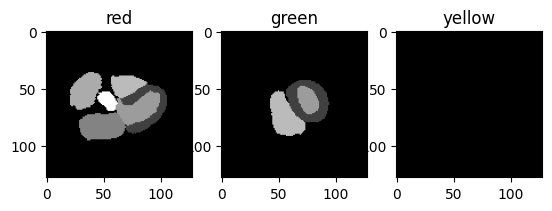

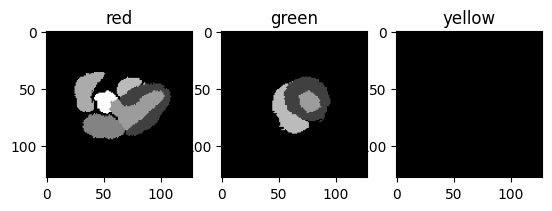

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


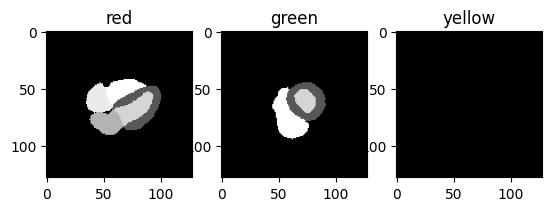

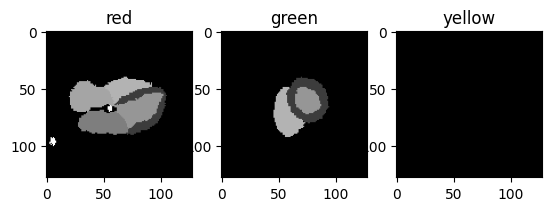

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


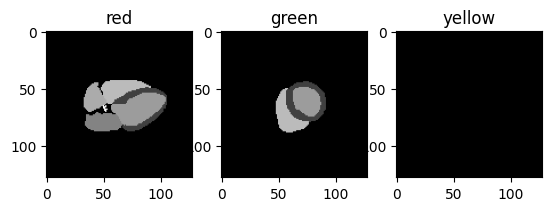

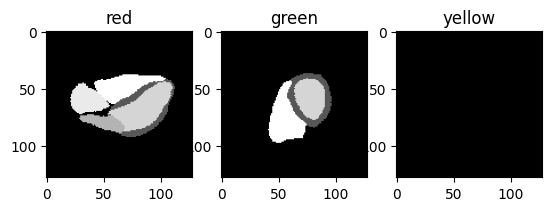

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


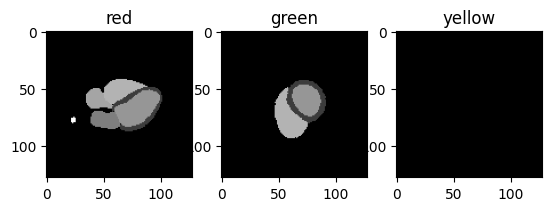

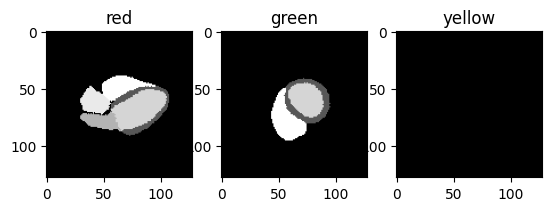

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


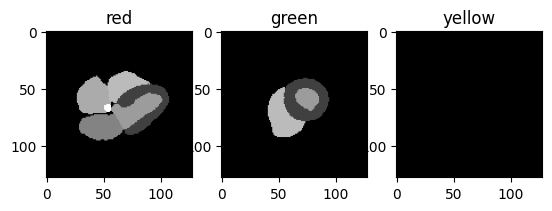

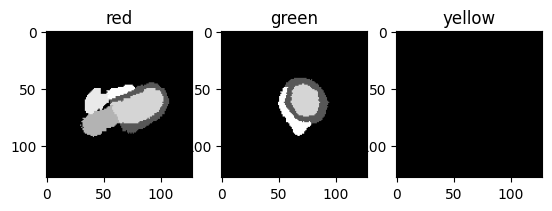

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


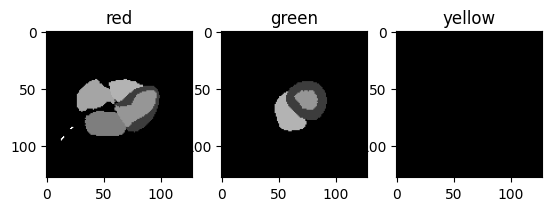

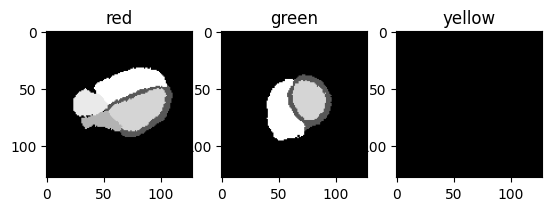

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


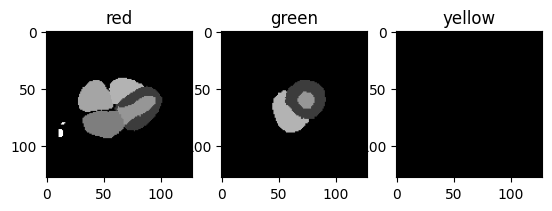

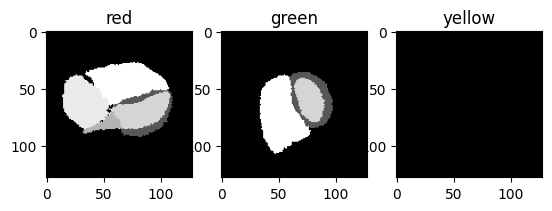

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


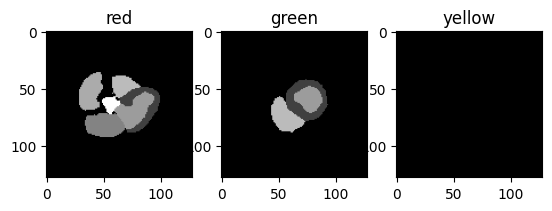

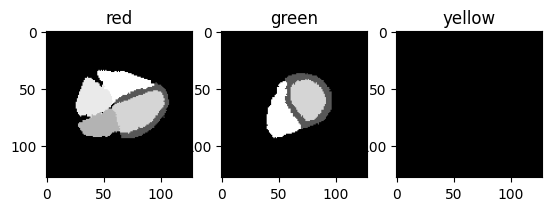

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


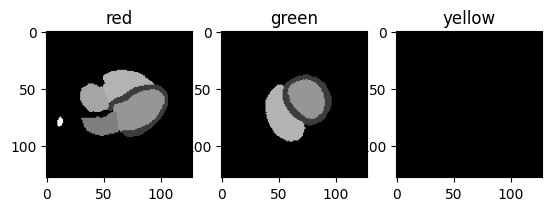

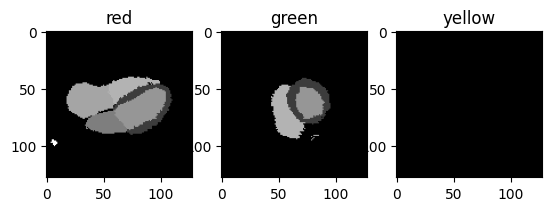

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


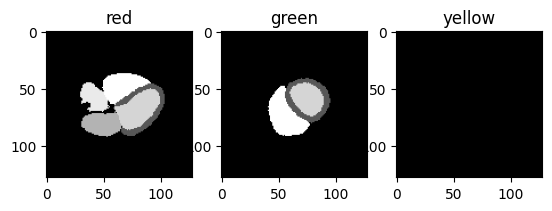

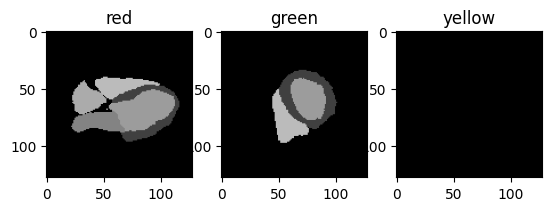

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


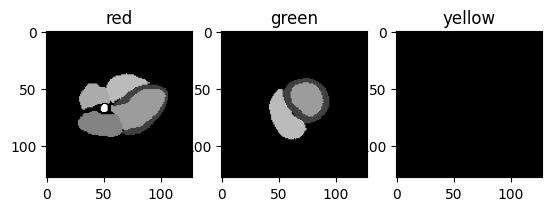

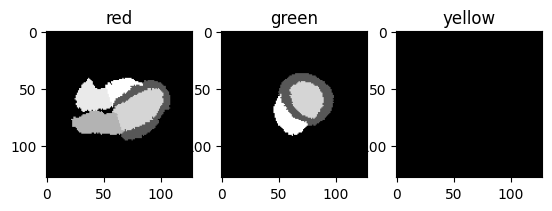

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


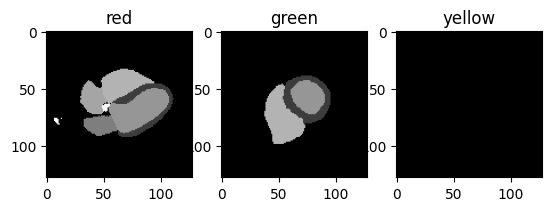

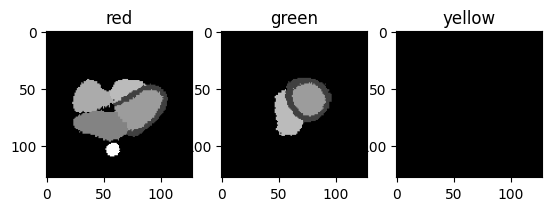

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


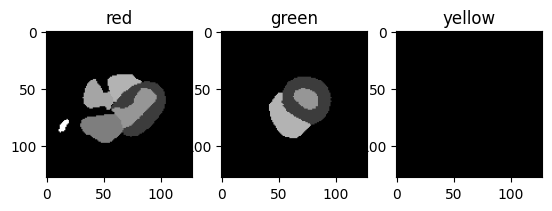

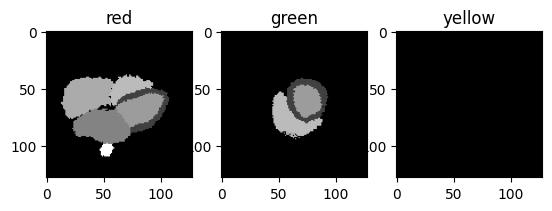

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


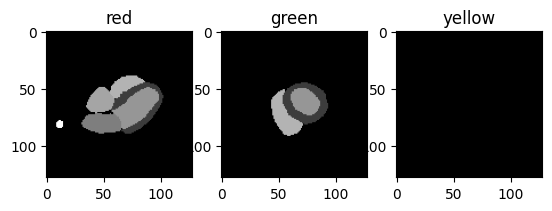

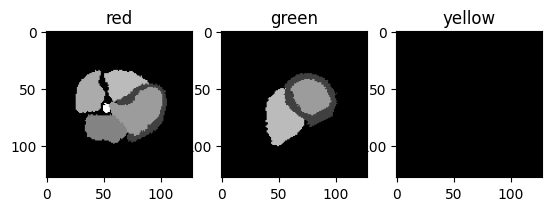

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


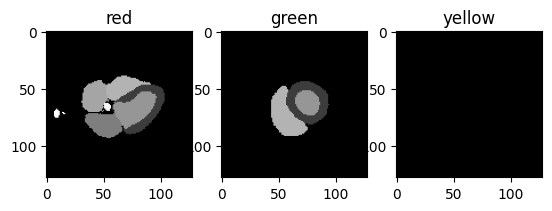

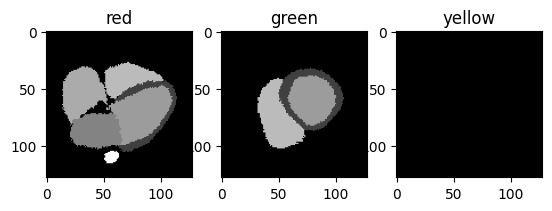

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


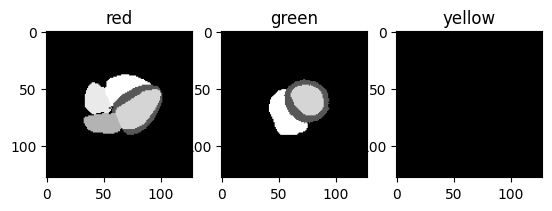

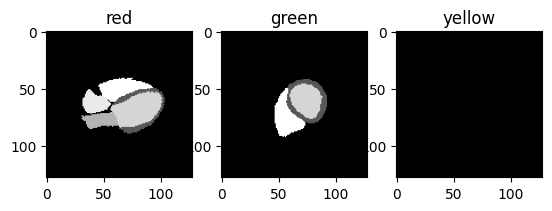

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


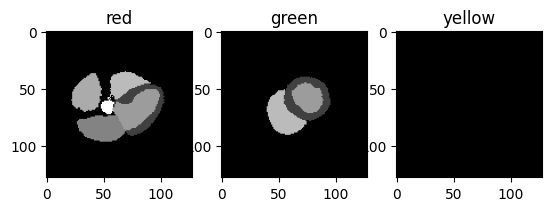

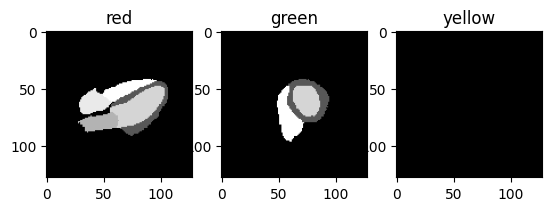

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


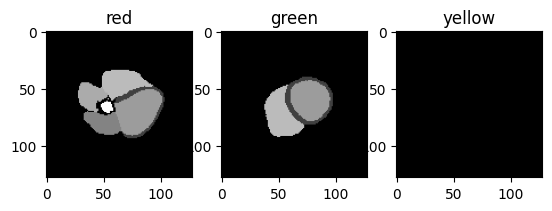

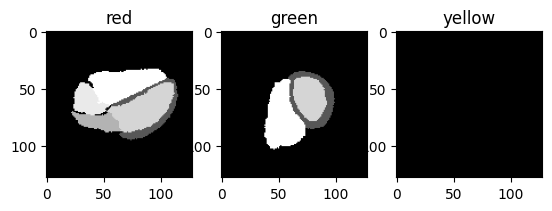

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


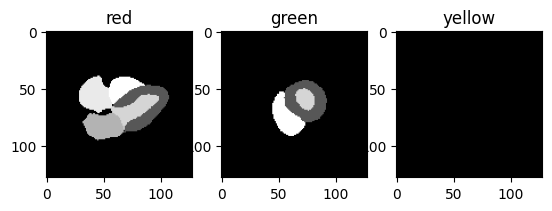

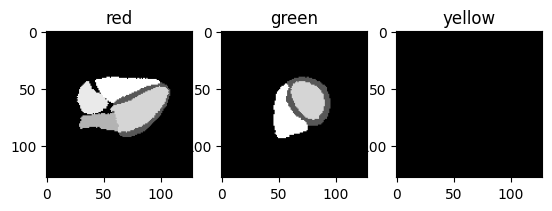

/shared/slice_inflate/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


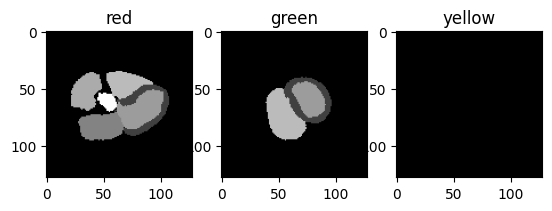

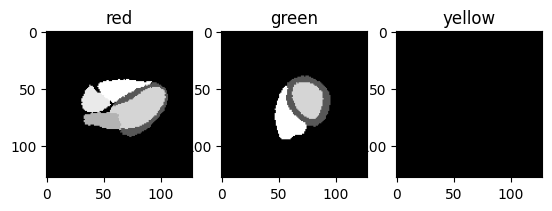

In [20]:
mmwhs_base_path = "../../data/MMWHS"

red_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_HLA_red_slice_to_ras.mat"))
yellow_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA_yellow_slice_to_ras.mat"))

FOV_MM = torch.tensor([224,224,224])
FOV_VOX = torch.tensor([128,128,128])

for p_id in range(1001,1021):
    for mod_id in ['ct', 'mr']:
        mri_path = Path(mmwhs_base_path, f"{mod_id}_train/{mod_id}_train_{p_id}_image.nii.gz")
        mri_gt_path = Path(mmwhs_base_path, f"{mod_id}_train/{mod_id}_train_{p_id}_label.nii.gz")

        if not (mri_path.is_file() and mri_gt_path.is_file()): 
            mri_path = Path(mmwhs_base_path, f"{mod_id}_test_selection/{mod_id}_train_{p_id}_image.nii.gz")
            mri_gt_path = Path(mmwhs_base_path, f"{mod_id}_test_selection/{mod_id}_train_{p_id}_label.nii.gz")

        nii = nib.load(mri_path)
        gt_nii = nib.load(mri_gt_path)

        align_mat = torch.from_numpy(np.loadtxt(f"../../data/MMWHS/preprocessed/f1002mr_m{p_id}{mod_id}.mat"))
        hla_mat = align_mat @ red_slice_to_ras_mat
        sa_mat =  align_mat @ yellow_slice_to_ras_mat

        data = torch.as_tensor(nii.get_fdata()).unsqueeze(0).unsqueeze(0)
        gt_data = torch.as_tensor(gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0)
        affine = torch.as_tensor(nii.affine)
        gt_affine = torch.as_tensor(gt_nii.affine)

        hla_volume, _ = nifti_transform(data, affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX)
        hla_label, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)
        sa_volume, _ = nifti_transform(data, affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX)
        sa_label, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)

        hla_slc = cut_slice(hla_label).squeeze()
        sa_slc = cut_slice(sa_label).squeeze()

        plot_slices(hla_slc, sa_slc, torch.zeros_like(sa_slc), vmax=hla_slc.max().item())

# Visualize HLA and SA view (from prealigned images and labels)

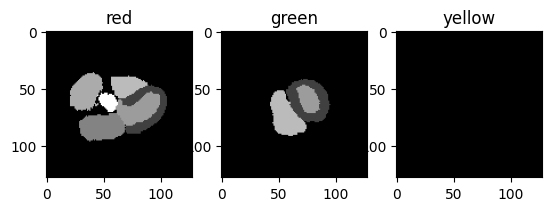

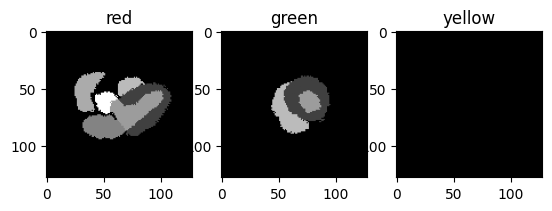

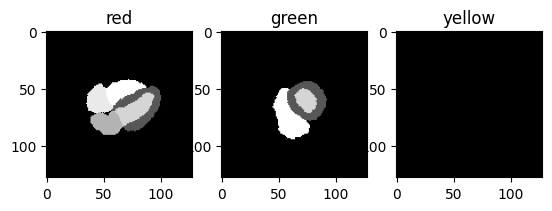

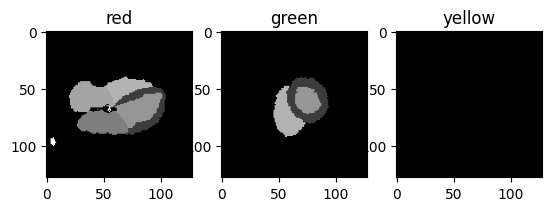

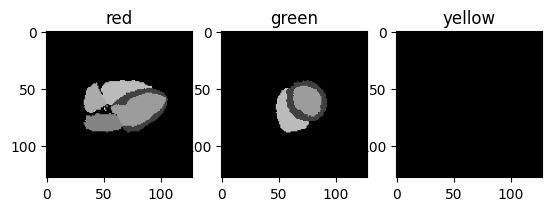

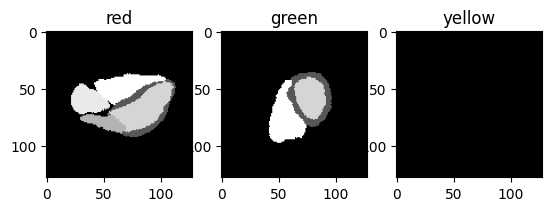

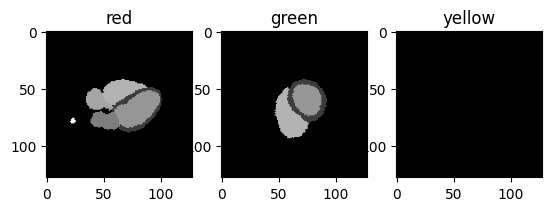

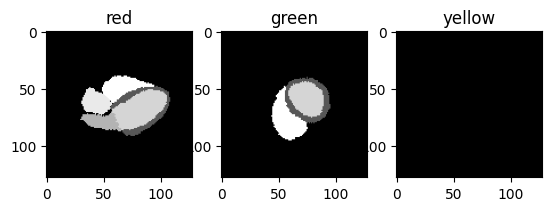

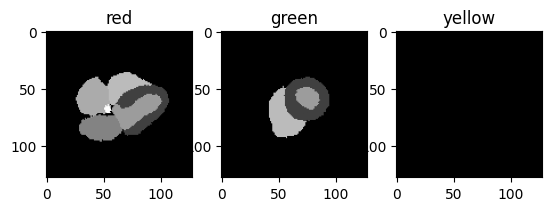

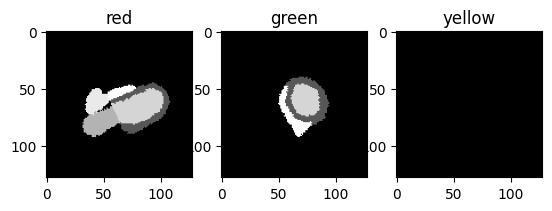

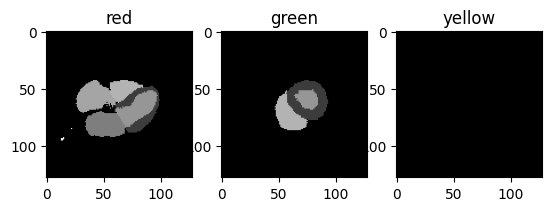

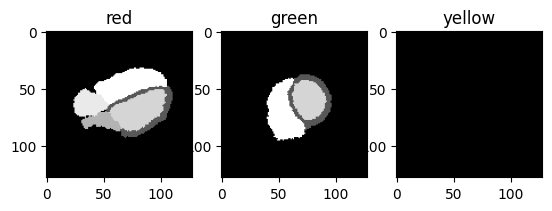

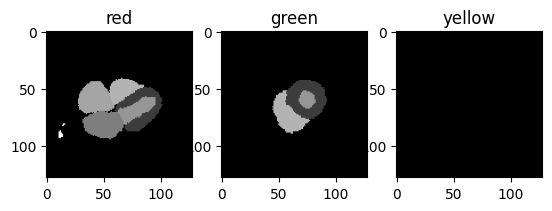

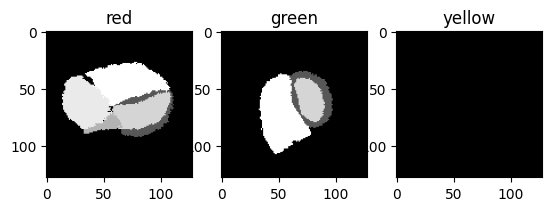

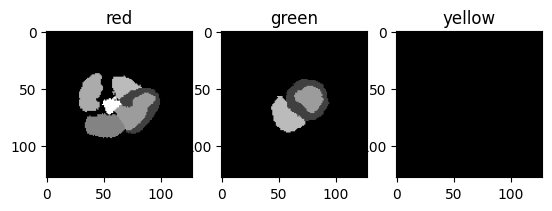

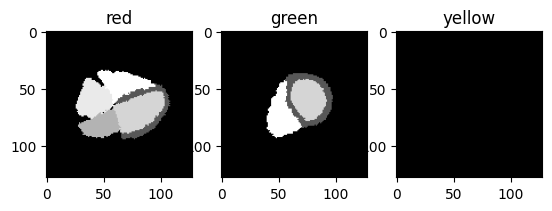

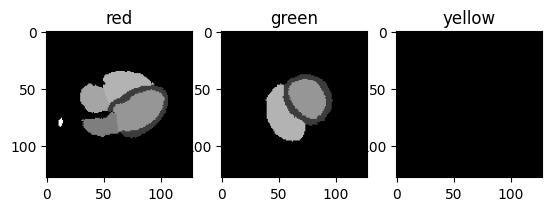

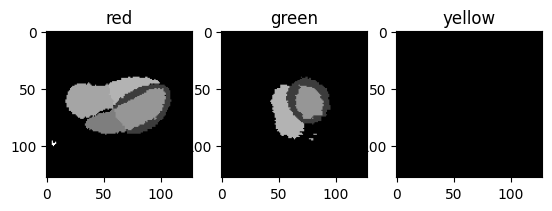

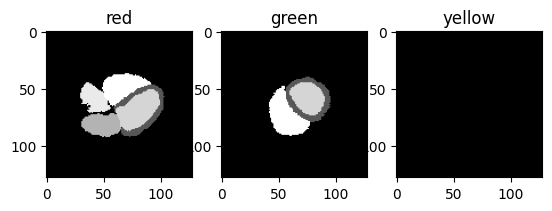

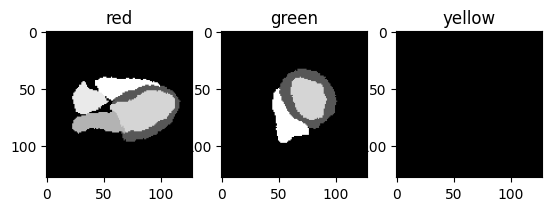

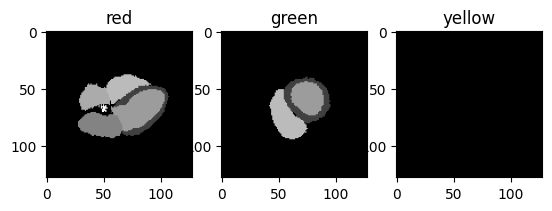

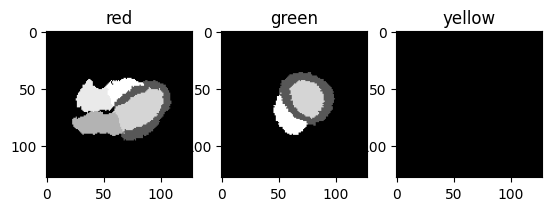

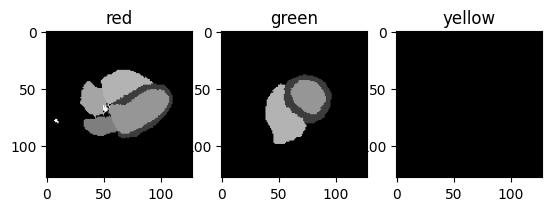

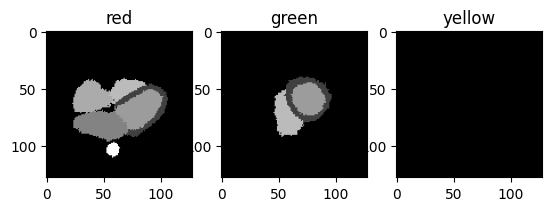

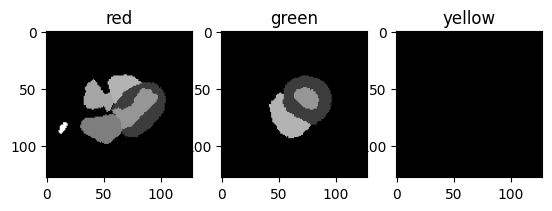

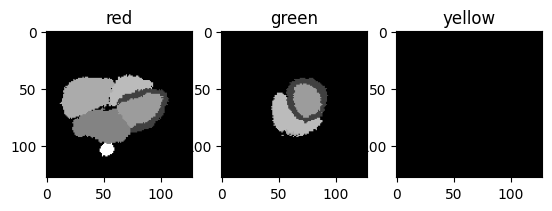

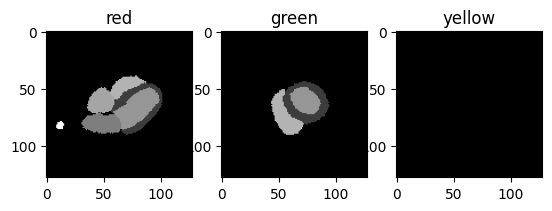

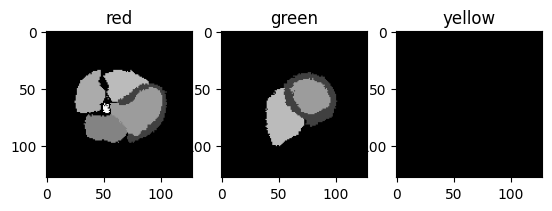

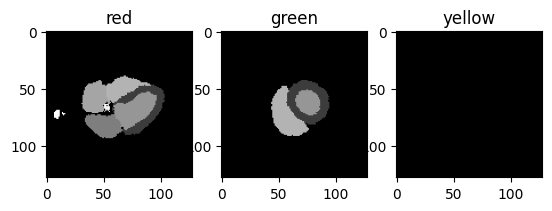

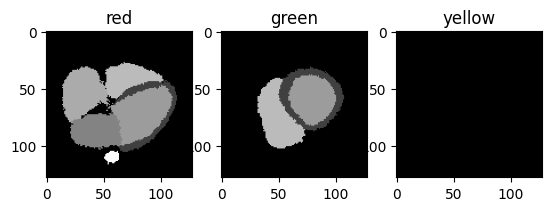

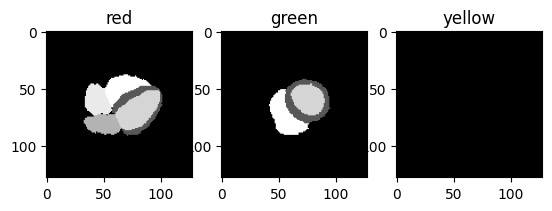

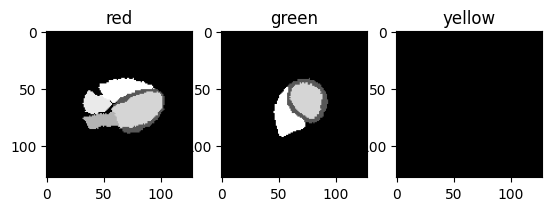

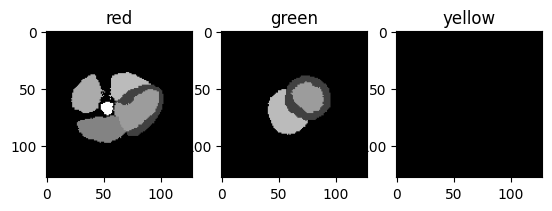

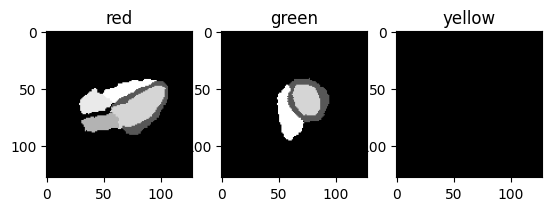

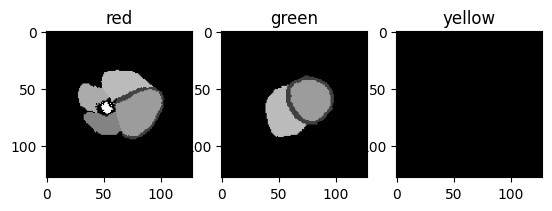

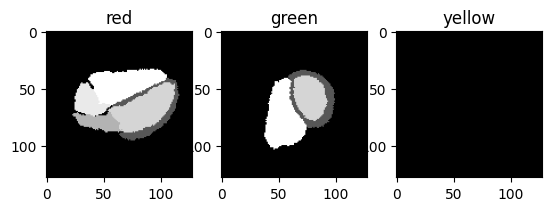

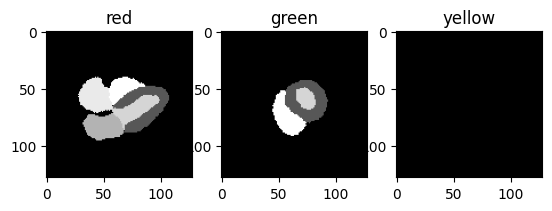

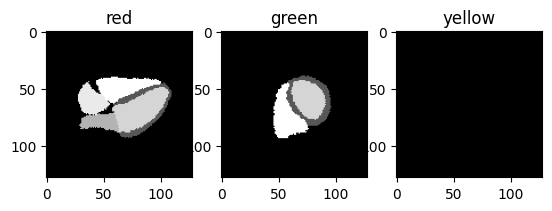

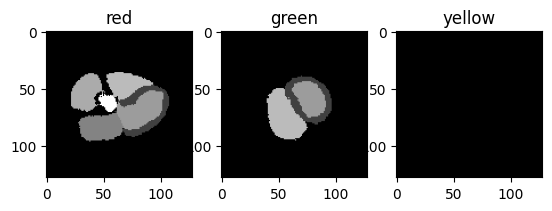

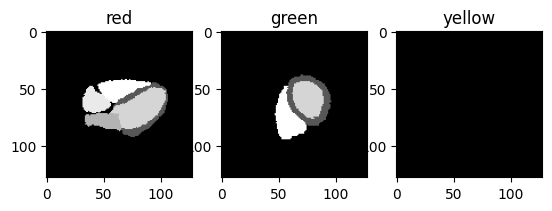

In [21]:
mmwhs_base_path = "../../data/MMWHS"

red_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_HLA_red_slice_to_ras.mat"))
yellow_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA_yellow_slice_to_ras.mat"))

FOV_MM = torch.tensor([224,224,224])
FOV_VOX = torch.tensor([128,128,128])

for p_id in range(1001,1021):
    for mod_id in ['ct', 'mr']:
        mri_path = Path(mmwhs_base_path, f"{mod_id}_registered_train/{mod_id}_train_{p_id}_image_registered.nii.gz")
        mri_gt_path = Path(mmwhs_base_path, f"{mod_id}_registered_train/{mod_id}_train_{p_id}_label_registered.nii.gz")

        if not (mri_path.is_file() and mri_gt_path.is_file()): 
            mri_path = Path(mmwhs_base_path, f"{mod_id}_registered_test_selection/{mod_id}_train_{p_id}_image_registered.nii.gz")
            mri_gt_path = Path(mmwhs_base_path, f"{mod_id}_registered_test_selection/{mod_id}_train_{p_id}_label_registered.nii.gz")

        nii = nib.load(mri_path)
        gt_nii = nib.load(mri_gt_path)

        hla_mat = red_slice_to_ras_mat
        sa_mat = yellow_slice_to_ras_mat

        data = torch.as_tensor(nii.get_fdata()).unsqueeze(0).unsqueeze(0)
        gt_data = torch.as_tensor(gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0)
        affine = torch.as_tensor(nii.affine)
        gt_affine = torch.as_tensor(gt_nii.affine)

        hla_volume, _ = nifti_transform(data, affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX)
        hla_label, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)
        sa_volume, _ = nifti_transform(data, affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX)
        sa_label, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)

        hla_slc = cut_slice(hla_label).squeeze()
        sa_slc = cut_slice(sa_label).squeeze()

        plot_slices(hla_slc, sa_slc, torch.zeros_like(sa_slc), vmax=hla_slc.max().item())